In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

2023-05-03 11:09:40.343795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 11:09:41.202237: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-03 11:09:41.202361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

# 1) 로이터 뉴스 데이터 탐색적 분석

In [2]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    # 출현 빈도 상위 몇 위까지의 단어를 불러올지 설정합니다.
    # 100일 경우 출연 빈도 상위 100위까지의 단어를 불러옵니다.
    # 모든 단어를 불러오려면 None으로 설정합니다.
    num_words = None,
    test_split = 0.2
)

print("훈련용 뉴스 기사: {}".format(len(X_train)))
print("테스트용 뉴스 기사: {}".format(len(X_test)))
print("카테고리 개수: {}".format(len(set(y_train))))
print("첫 번째 훈련용 뉴스 기사: ", X_train[0])
print("첫 번째 훈련용 뉴스 기사의 카테고리: ", y_train[0])

훈련용 뉴스 기사: 8982
테스트용 뉴스 기사: 2246
카테고리 개수: 46
첫 번째 훈련용 뉴스 기사:  [1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
첫 번째 훈련용 뉴스 기사의 카테고리:  3


첫 번재 훈련용 뉴스 기사의 데이터는 토큰화와 정수 인코딩을 마친 상태이기 때문에 텍스트가 아니라 정수 리스트입니다.

정수 인코딩 과정에서 단어의 출현 빈도 순위에 따라 정수를 부여하였습니다.

예를 들어 1은 출현 빈도 1위의 단어이며, 27,595는 출현 빈도 27.595위의 단어입니다.

### 훈련용 뉴스 기사의 길이

뉴스 기사의 최대 길이: 2376
뉴스 기사의 평균 길이: 145.5398574927633


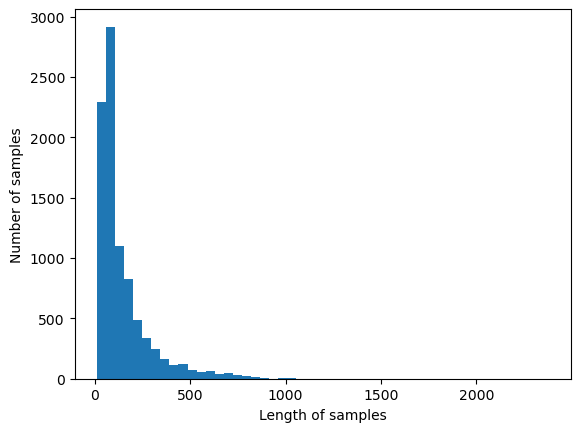

In [3]:
print("뉴스 기사의 최대 길이: {}".format(max(map(len, X_train))))

print("뉴스 기사의 평균 길이: {}".format(sum(map(len, X_train)) / len(X_train)))

plt.hist([len(sample) for sample in X_train], bins = 50)
plt.xlabel("Length of samples")
plt.ylabel("Number of samples")
plt.show()

### 훈련용 뉴스의 카테고리 분포

<AxesSubplot:ylabel='count'>

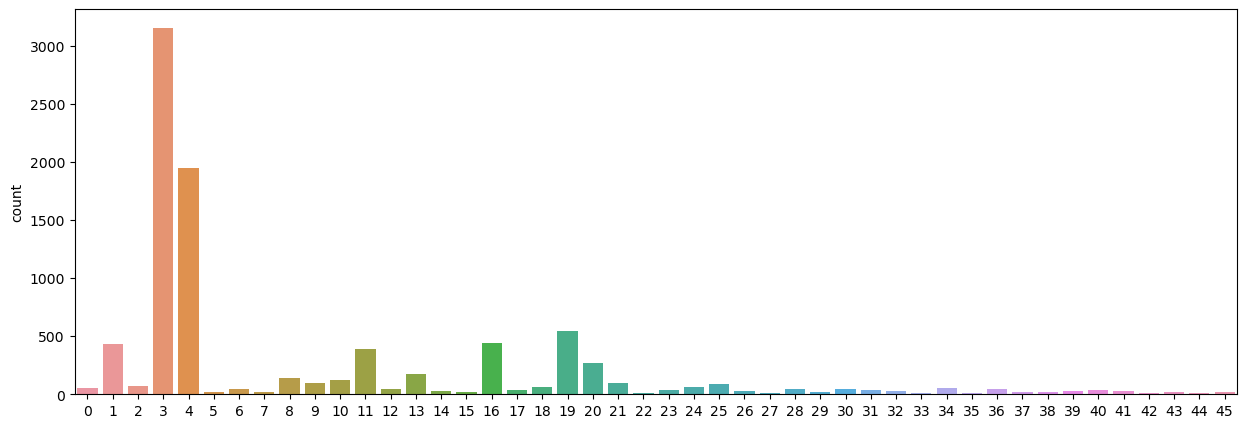

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x = y_train)

In [5]:
unique_category, counts_category = np.unique(y_train, return_counts = True)

print(np.asarray((unique_category, counts_category)))

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 인덱스에 매핑된 단어 확인

In [6]:
word_to_index = reuters.get_word_index()

print(list(word_to_index.keys())[:10])
print(list(word_to_index.values())[:10])

['mdbl', 'fawc', 'degussa', 'woods', 'hanging', 'localized', 'sation', 'chanthaburi', 'refunding', 'hermann']
[10996, 16260, 12089, 8803, 13796, 20672, 20673, 20675, 10997, 8804]


In [7]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value + 3] = key

### 특별 토큰 추가

인덱스 0: 패딩 토큰

1: 문장 시작 토큰 sos

2: OVV 토큰 unk

In [8]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

In [9]:
print("출현 빈도 1위 단어: {}".format(index_to_word[1 + 3]))
print("출현 빈도 100위 단어: {}".format(index_to_word[100 + 3]))

출현 빈도 1위 단어: the
출현 빈도 100위 단어: group


특별 토큰을 제외하고 출현 빈도 1위의 단어를 구하기 위해 4번째 인덱스에 매핑된 단어를 구합니다.

### 첫 번째 훈련용 뉴스 기사를 단어로 복원

In [10]:
print(" ".join([index_to_word[index] for index in X_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


전처리한 문장이기 때문에 완전한 문장으로 복원되지 않습니다.

# 2) LSTM으로 로이터 뉴스 분류

1. 훈련 과정에서 출현 빈도 상위 1000개 단어만 사용

2. 뉴스의 길이는 모두 다르므로 길이 100으로 패딩

3. 원-핫 인코딩

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

voca_size = 1000
max_len = 100

(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words = voca_size,
    test_split = 0.2
)

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

- 임베딩 벡터의 차원 = 128

- 은닉 상태의 크기 = 128

- 다 대 일 구조의 LSTM

- 46개의 카테고리 중 하나를 예측하여 선택(다중 클래스 분류 문제)
    - 출력층에서 소프트맥스 회귀를 사용
    - 손실 함수 = 크로스 엔트로피 함수

- 배치의 크기 = 128

- 에포크 = 30

- 검증 데이터 = X_test, y_test

- 검증 과정에서 손실이 4회 연속 발생하면(과적합 징후) 훈련을 조기 종료

- ModelCheckpoint를 사용하여 검증 정확도가 이전보다 좋은 경우에만 모델을 저장

In [12]:
embedding_dim = 128
hidden_units = 128
num_classes = 46

model = Sequential()
model.add(Embedding(voca_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation = "softmax"))

es = EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    verbose = 1,
    patience = 4
)

mc = ModelCheckpoint(
    "best_model.h5",
    monitor = "val_acc",
    mode = "max",
    verbose = 1,
    save_best_only = True
)

model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = "acc"
)

history = model.fit(
    X_train, y_train,
    batch_size = 128,
    epochs = 30,
    callbacks = [es, mc],
    validation_data = (X_test, y_test)
)

2023-05-03 11:09:45.688854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 11:09:45.700645: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 11:09:45.702268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-03 11:09:45.704869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Epoch 1/30


2023-05-03 11:09:49.273431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-05-03 11:09:50.151386: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa4f01c45e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-03 11:09:50.151428: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-05-03 11:09:50.156844: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-03 11:09:50.335421: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/71 [==============================] - ETA: 0s - loss: 2.6108 - acc: 0.3464
Epoch 1: val_acc improved from -inf to 0.46037, saving model to best_model.h5
71/71 [==============================] - 12s 120ms/step - loss: 2.6108 - acc: 0.3464 - val_loss: 2.3470 - val_acc: 0.4604
Epoch 2/30
71/71 [==============================] - ETA: 0s - loss: 2.0982 - acc: 0.4781
Epoch 2: val_acc did not improve from 0.46037
71/71 [==============================] - 3s 45ms/step - loss: 2.0982 - acc: 0.4781 - val_loss: 2.1543 - val_acc: 0.4590
Epoch 3/30
71/71 [==============================] - ETA: 0s - loss: 1.8998 - acc: 0.5160
Epoch 3: val_acc improved from 0.46037 to 0.55833, saving model to best_model.h5
71/71 [==============================] - 3s 37ms/step - loss: 1.8998 - acc: 0.5160 - val_loss: 1.7760 - val_acc: 0.5583
Epoch 4/30
71/71 [==============================] - ETA: 0s - loss: 1.7273 - acc: 0.5533
Epoch 4: val_acc did not improve from 0.55833
71/71 [==============================] - 1

In [13]:
best_model = load_model("best_model.h5")

print("\n테스트 정확도: {0:.4f}".format(best_model.evaluate(X_test, y_test)[1]))

71/71 [==============================] - 1s 4ms/step - loss: 1.2059 - acc: 0.7177

테스트 정확도: 0.7177


검증 과정에서 사용한 X_test, y_test 데이터를 테스트에서 재사용하였습니다.

데이터가 충분하다면 검증 데이터와 테스트 데이터를 분리하는 것이 바람직합니다.

스팸 메일 분류에서는 test_split과 함께 validation_split을 사용하여 검증 데이터와 테스트 데이터를 분리하였습니다.

### 에포크별 훈련 손실 및 검증 손실

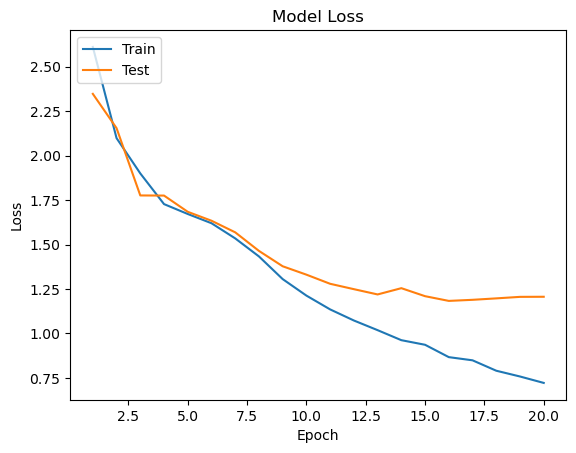

In [14]:
epochs = range(1, len(history.history["acc"]) + 1)
plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

에포크가 커질수록 검증 손실의 감소폭이 줄어드는 경향이 보입니다.

이는 과적합의 징후입니다.